#### Libraries used: Numpy, OS, OpenCV, Matplotlib, Tensorflow

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout

### 1. Loading the images, rescaling and performing validation split.

In [8]:
train_dir = r"C:\Users\91909\Desktop\ML\DATA\PlantVillage-Dataset-master\PlantVillage-Dataset-master\raw\PLANT_VILLAGE_SPLIT\train"
test_dir = r"C:\Users\91909\Desktop\ML\DATA\PlantVillage-Dataset-master\PlantVillage-Dataset-master\raw\PLANT_VILLAGE_SPLIT\test"
val_dir = r"C:\Users\91909\Desktop\ML\DATA\PlantVillage-Dataset-master\PlantVillage-Dataset-master\raw\PLANT_VILLAGE_SPLIT\val"

In [9]:
IMAGE_SIZE = (224, 224) # Compatible with the input size the pre-trained model was trained on
BATCH_SIZE = 32

### 2. Defining functions to convert all data from RGB to HSV to yield better results.

In [10]:
def rgb_to_hsv(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)  # Converting RGB to HSV
    return hsv_image

def preprocess_function(image):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image

In [11]:
datagen = ImageDataGenerator(rescale=1.0/255,
                             preprocessing_function=preprocess_function)

# data_generator = datagen.flow_from_directory(
#     train_dir,
#     target_size=IMAGE_SIZE,
#     batch_size=BATCH_SIZE,
#     class_mode='categorical',
#     shuffle=True
# )

# images, labels = next(data_generator)

### 3. Preview of the dataset.

In [12]:
# plt.figure(figsize=(15, 15))
# for i in range(16):
#     plt.subplot(4, 4, i+1)
#     plt.imshow(images[i])
#     plt.title(f"Label: {list(data_generator.class_indices.keys())[np.argmax(labels[i])]}")
#     plt.axis('off')
# plt.show()

### 4. Displaying the distribution of the data.

In [13]:
# cat_counts = {category: len(os.listdir(os.path.join(train_dir, category)))
#                    for category in os.listdir(train_dir)
#                    if os.path.isdir(os.path.join(train_dir, category))}

# categories = list(cat_counts.keys())
# counts = list(cat_counts.values())

# plt.figure(figsize=(10, 6))
# plt.barh(categories, counts, color='red')
# plt.xlabel('Number of Images')
# plt.ylabel('Categories')
# plt.title('Distribution of Categories')
# plt.show()

### 5. Loading data for training and validation.

In [14]:
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 32572 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.
Found 10885 images belonging to 38 classes.


### 6. Importing Xception model.

In [15]:
from tensorflow.keras.applications import VGG16

### 7. Building new Dense layers atop the base model.

In [16]:
base_model = VGG16(weights='imagenet' ,include_top=False , input_shape=(224,224,3), pooling='max' )

model = Sequential()
model.add(base_model)

model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dense(38, activation='softmax'))

for layer in base_model.layers:
    layer.trainable = False

### 8. Using Adamax optimizer with custom learning rate.

In [17]:
model.compile(tf.keras.optimizers.Adam(learning_rate = 0.001), # Learning rate of 0.001 was set after test training multiple times with different values
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
model.build(input_shape=(None, 224, 224, 3))

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 38)                2470      
                                                                 
Total params: 14,752,038
Trainable params: 36,326
Non-trainable params: 14,715,712
_______________________________________

### 9. Defining early stopping to stop overfitting during trining of the model.

In [20]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=5, restore_best_weights=True) # min_delta was chosen 0.005 after multiple testing with different values

In [21]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
1018/1018 [==============================] - 558s 532ms/step - loss: 0.6961 - accuracy: 0.7988 - val_loss: 0.3150 - val_accuracy: 0.8978
Epoch 2/50
1018/1018 [==============================] - 533s 524ms/step - loss: 0.2704 - accuracy: 0.9113 - val_loss: 0.2608 - val_accuracy: 0.9122
Epoch 3/50
1018/1018 [==============================] - 553s 544ms/step - loss: 0.2060 - accuracy: 0.9310 - val_loss: 0.2500 - val_accuracy: 0.9158
Epoch 4/50
1018/1018 [==============================] - 579s 568ms/step - loss: 0.1663 - accuracy: 0.9435 - val_loss: 0.2412 - val_accuracy: 0.9214
Epoch 5/50
1018/1018 [==============================] - 550s 540ms/step - loss: 0.1427 - accuracy: 0.9527 - val_loss: 0.2476 - val_accuracy: 0.9210
Epoch 6/50
1018/1018 [==============================] - 509s 500ms/step - loss: 0.1262 - accuracy: 0.9559 - val_loss: 0.2543 - val_accuracy: 0.9207
Epoch 7/50
1018/1018 [==============================] - 513s 504ms/step - loss: 0.1141 - accuracy: 0.9588 - val_

### 91% accuracy achieved.
### 10. Plotting the loss and accuracy to check for overfitting.

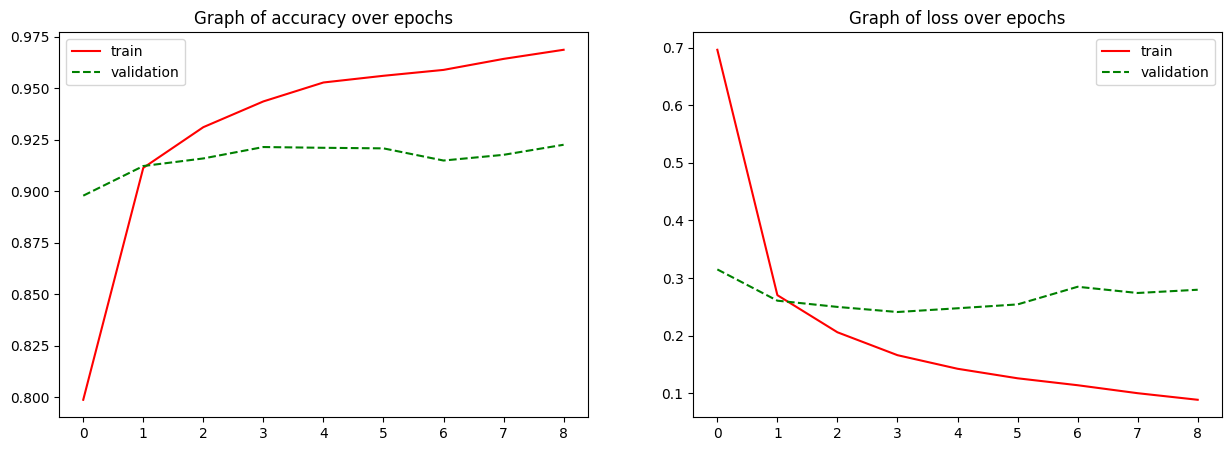

In [22]:
def printplot(history):
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history["accuracy"], color="red", label="train")
        plt.plot(history.history["val_accuracy"], color="green", label="validation", linestyle="dashed")
        plt.title("Graph of accuracy over epochs")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history["loss"], color="red", label="train")
        plt.plot(history.history["val_loss"], color="green", label="validation", linestyle="dashed")
        plt.title("Graph of loss over epochs")
        plt.legend()

printplot(history)

### 11. Minimal overfitting observed as the both the graphs of training and validation converge together.

### 12. Saving the model for future uses.

In [23]:
model.save('VGG16.h5')

### 13. Testing the model on a random image from the dataset.

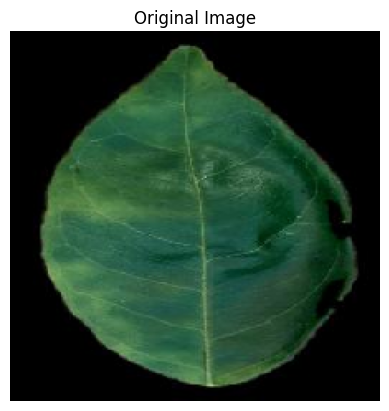

1/1 [==============================] - 0s 421ms/step
Predicted Class: Orange___Haunglongbing_(Citrus_greening)
Actual Class: Orange___Haunglongbing_(Citrus_greening)


In [24]:
images, labels = next(val_generator)

selected_image = images[0]
selected_label = labels[0]

plt.imshow(selected_image)
plt.title("Original Image")
plt.axis('off')
plt.show()

image_for_prediction = np.expand_dims(selected_image, axis=0)

predicted_probs = model.predict(image_for_prediction)
predicted_class = np.argmax(predicted_probs, axis=1)

actual_class = np.argmax(selected_label)

class_names = list(val_generator.class_indices.keys())

predicted_class_name = class_names[predicted_class[0]]
actual_class_name = class_names[actual_class]

print(f"Predicted Class: {predicted_class_name}")
print(f"Actual Class: {actual_class_name}")

In [25]:
# Evaluate model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

341/341 [==============================] - 239s 701ms/step - loss: 0.2527 - accuracy: 0.9210
Test Accuracy: 92.10%
Test Loss: 0.2527
